### Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot
import math
from keras import callbacks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.utils import plot_model

### Importing Data

In [2]:
train = pd.read_csv("../input/ventilator-pressure-prediction/train.csv")
test = pd.read_csv("../input/ventilator-pressure-prediction/test.csv")
id = test['id']
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])
train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,20,50,0.000000,0.083334,0,5.837492
1,1,20,50,0.033652,18.383041,0,5.907794
2,1,20,50,0.067514,22.509278,0,7.876254
3,1,20,50,0.101542,22.808822,0,11.742872
4,1,20,50,0.135756,25.355850,0,12.234987


### Checking for Features Datatype

In [3]:
def check(df):
    categorical_data = []
    numerical_data = []
    for i in df.columns:
        if df[i].value_counts().count() > 10:
            numerical_data.append(i)
        else:
            categorical_data.append(i)
    return([numerical_data,categorical_data])

In [4]:
t = check(train)
print("Numerical columns: ",t[0])
print("Categorical columns: ",t[1])

Numerical columns:  ['breath_id', 'time_step', 'u_in', 'pressure']
Categorical columns:  ['R', 'C', 'u_out']


### Removing Pressure Feature's Outliers

In [5]:
train['pressure'] = np.where(train['pressure'] < 0, np.nan, train['pressure'])
train = train.dropna()
train.isnull().sum()

breath_id    0
R            0
C            0
time_step    0
u_in         0
u_out        0
pressure     0
dtype: int64

In [6]:
x_train = train.iloc[:,0:6]
y_train = train.iloc[:,6]

### Editing Time Step

In [7]:
x_train['time_step'] = pd.cut(x=x_train['time_step'], bins=[-0.99, 0.5, 1, 1.5, 2, 2.5, 3], labels=[0,1,2,3,4,5])
x_train['time_step'] = x_train['time_step'].astype('int64')
x_train.head()

,breath_id,R,C,time_step,u_in,u_out
0,1,20,50,0,0.083334,0
1,1,20,50,0,18.383041,0
2,1,20,50,0,22.509278,0
3,1,20,50,0,22.808822,0
4,1,20,50,0,25.355850,0


In [8]:
test['time_step'] = pd.cut(x=test['time_step'], bins=[-0.99, 0.5, 1, 1.5, 2, 2.5, 3], labels=[0,1,2,3,4,5])
test['time_step'] = test['time_step'].astype('int64')
test.head()

,breath_id,R,C,time_step,u_in,u_out
0,0,5,20,0,0.000000,0
1,0,5,20,0,7.515046,0
2,0,5,20,0,14.651675,0
3,0,5,20,0,21.230610,0
4,0,5,20,0,26.320956,0


### Adding Extra Features

In [9]:
def create_new_feat(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    #print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    #print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']
    #print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    #print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    #print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"})\
                                                               .reset_index(level=0,drop=True))
    #print("Step-6...Completed")
    
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    #print("Step-7...Completed")
    
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    #print("Step-8...Completed")
    
    return df

In [10]:
x_train = create_new_feat(x_train)
#x_train = x_train.fillna(x_train.min())

test = create_new_feat(test)
#test = test.fillna(test.min())

In [11]:
t = check(x_train)
print("Numerical columns: ",t[0])
print("\nCategorical columns: ",t[1])

Numerical columns:  ['breath_id', 'u_in', 'cross', 'area', 'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1', 'u_in_lag_back1', 'u_in_lag2', 'u_in_lag_back2', 'u_in_lag3', 'u_in_lag_back3', 'u_in_lag4', 'u_in_lag_back4', 'breath_id__u_in__max', 'breath_id__u_in__mean', 'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff1', 'u_in_diff2', 'u_in_diff3', 'u_in_diff4', 'count', 'u_in_cummean', 'breath_id_lag', 'breath_id_lag2', 'breath_id__u_in_lag', 'breath_id__u_in_lag2', 'ewm_u_in_mean', '15_in_sum', '15_in_min', '15_in_max', '15_in_mean', 'u_in_lagback_diff1', 'u_in_lagback_diff2']

Categorical columns:  ['time_step', 'u_out', 'cross2', 'u_out_lag1', 'u_out_lag_back1', 'u_out_lag2', 'u_out_lag_back2', 'u_out_lag3', 'u_out_lag_back3', 'u_out_lag4', 'u_out_lag_back4', 'u_out_diff1', 'u_out_diff2', 'u_out_diff3', 'u_out_diff4', 'one', 'breath_id_lagsame', 'breath_id_lag2same', 'time_step_diff', 'u_out_lagback_diff1', 'u_out_lagback_diff2', 'R_20', 'R_5', 'R_50', 'C_10', 'C_20'

In [12]:
x_train = x_train.drop(['breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same'],axis=1)

test = test.drop(['breath_id','one','count','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same'],axis=1)

print(f"Train: {x_train.shape} \nTest: {test.shape}")

Train: (6032287, 64) 
Test: (4024000, 64)


### Normalize the Data using Min Max Scalar

In [13]:
scaler1 = RobustScaler()
scaler2 = RobustScaler()
scaler3 = RobustScaler()

x_train = scaler1.fit_transform(x_train)
test = scaler3.fit_transform(test)
y_train = scaler2.fit_transform(y_train.values.reshape(-1,1))

In [14]:
x_train = x_train.reshape(-1,1,64)
test = test.reshape(-1,1,64)
y_train = y_train.reshape(-1,1,1)

### Create and fit the LSTM network

In [15]:
model = Sequential()
model.add(LSTM(150,input_shape=(1,64),return_sequences=True))
model.add(LSTM(100,return_sequences=True,input_shape=(1,64)))
model.add(LSTM(64,return_sequences=True))
model.add(Dense(16,activation='selu'))
model.add(Dense(1))
model.summary()

model.compile(loss='mae',optimizer='adam')

2021-11-01 06:49:32.604267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 06:49:32.713927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 06:49:32.714617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-01 06:49:32.716907: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 150)            129000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            100400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 64)             42240     
_________________________________________________________________
dense (Dense)                (None, 1, 16)             1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 1)              17        
Total params: 272,697
Trainable params: 272,697
Non-trainable params: 0
_________________________________________________________________


In [16]:
#epoch=300
earlystopping = callbacks.EarlyStopping(monitor ="val_loss",mode ="min",patience = 3,restore_best_weights = True)
model.fit(x_train,y_train,epochs = 50,batch_size = 512,callbacks =[earlystopping])

2021-11-01 06:49:36.990868: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1544265472 exceeds 10% of free system memory.
2021-11-01 06:49:38.552132: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1544265472 exceeds 10% of free system memory.
2021-11-01 06:49:39.811549: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2021-11-01 06:49:44.055617: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


11782/11782 [==============================] - 81s 6ms/step - loss: 0.1086
Epoch 2/50
11782/11782 [==============================] - 75s 6ms/step - loss: 0.0872
Epoch 3/50
11782/11782 [==============================] - 75s 6ms/step - loss: 0.0796
Epoch 4/50
11782/11782 [==============================] - 76s 6ms/step - loss: 0.0748
Epoch 5/50
11782/11782 [==============================] - 77s 7ms/step - loss: 0.0716
Epoch 6/50
11782/11782 [==============================] - 76s 6ms/step - loss: 0.0691
Epoch 7/50
11782/11782 [==============================] - 78s 7ms/step - loss: 0.0670
Epoch 8/50
11782/11782 [==============================] - 79s 7ms/step - loss: 0.0654
Epoch 9/50
11782/11782 [==============================] - 79s 7ms/step - loss: 0.0640
Epoch 10/50
11782/11782 [==============================] - 79s 7ms/step - loss: 0.0628
Epoch 11/50
11782/11782 [==============================] - 77s 7ms/step - loss: 0.0619
Epoch 12/50
11782/11782 [==============================] - 77s 

In [17]:
y_test = model.predict(test)

2021-11-01 07:54:46.057945: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1030144000 exceeds 10% of free system memory.
2021-11-01 07:54:47.092689: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1030144000 exceeds 10% of free system memory.


In [18]:
test_y = scaler2.inverse_transform(y_test.reshape(-1,1))
y_test.shape

(4024000, 1, 1)

In [19]:
y_train.shape

(6032287, 1, 1)

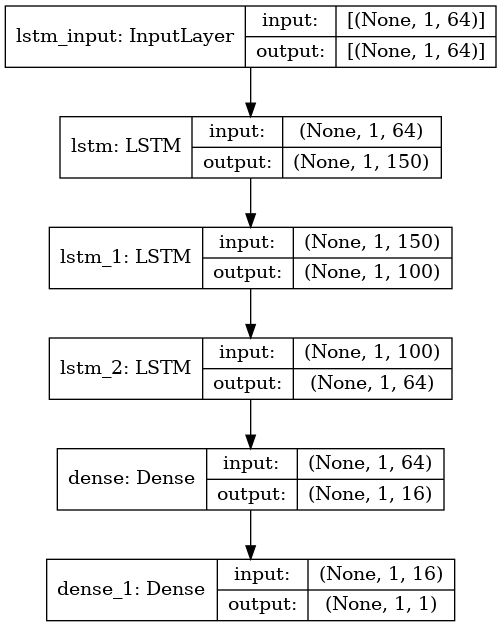

In [20]:
plot_model(
    model, 
    to_file='Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [21]:
prediction = pd.concat([id,pd.DataFrame(test_y)],axis=1)
prediction.columns=['id','pressure']
prediction.to_csv("Keras_Ann.csv",index=False)

In [22]:
prediction.head()

,id,pressure
0,1,6.085704
1,2,6.132731
2,3,6.970800
3,4,7.982039
4,5,9.076621
